Importing Necessary Libraries

In [1]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# To achieve reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
# Prioritizing GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

In [2]:
dataset_url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
zip_path = "ml-1m.zip"
extract_path = "ml-1m"

# Download if not exists
if not os.path.exists(zip_path):
    print("Downloading ML-1m dataset...")
    urllib.request.urlretrieve(dataset_url, zip_path)

# Extract if not exists
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)
print("Dataset ready!")

print("Extracted files:", os.listdir(extract_path))

# Load ratings
ratings_path = os.path.join(extract_path, "ml-1m/ratings.dat")

ratings = pd.read_csv(
    ratings_path,
    sep="::",
    engine="python",
    header=None,
    names=["user_id", "item_id", "rating", "timestamp"]
)

# Remap user and item ids to 0-based contiguous indices
user_ids = ratings["user_id"].unique()
item_ids = ratings["item_id"].unique()
user2idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
item2idx = {item_id: idx for idx, item_id in enumerate(item_ids)}
ratings["user_idx"] = ratings["user_id"].map(user2idx)
ratings["item_idx"] = ratings["item_id"].map(item2idx) # user_idx and item_idx allow efficient access

n_users = len(user2idx)
n_items = len(item2idx)
print("Number of users:", n_users, "Number of items:", n_items, "Number of ratings:", len(ratings))


Extracting dataset...
Dataset ready!
Extracted files: ['ml-1m']
Number of users: 6040 Number of items: 3706 Number of ratings: 1000209


Export Rating

In [7]:
from google.colab import files

ratings_to_export = ratings[["user_id", "item_id", "rating"]]

ratings_to_export.to_csv("ratings_to_export.csv", index=False)
files.download("ratings_to_export.csv")

ratings_to_export.head(5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   item_id    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
 4   user_idx   1000209 non-null  int64
 5   item_idx   1000209 non-null  int64
dtypes: int64(6)
memory usage: 45.8 MB


In [5]:
# Load Movies

genre_names = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                   'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                   'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


movies = pd.read_csv(
    "ml-1m/ml-1m/movies.dat",
    sep="::",
    encoding="latin-1",  # required for special characters
    header=None,
    engine="python",
    names=["movie_id", "title", "genres"]
)

# Split genres into one-hot encoded columns
for g in genre_names:
    movies[g] = movies["genres"].apply(lambda x: 1.0 if g in str(x) else 0.0)

# Drop unnecessary columns
movies = movies[["movie_id", "title"] + genre_names]

# Fix merge key mismatch
movies.rename(columns={"movie_id": "item_id"}, inplace=True)

# Map item IDs to movie titiles
ratings_and_titles = ratings.merge(movies, on="item_id")
ratings_and_titles.head(5)

# Prepare genre matrix
genre_matrix = ratings_and_titles[genre_names].values.astype(np.float32)

# Create idx2genre mapping
# idx = item_idx used in model, value = genre tensor
idx2genre = {
    item2idx[row['item_id']]: torch.tensor(row[genre_names].astype(np.float32).values)
    for _, row in ratings_and_titles.iterrows()
}

print("Movies loaded:", len(movies))
print("Example genres vector:", idx2genre[list(idx2genre.keys())[0]])

Movies loaded: 3883
Example genres vector: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**Exploratory Data Anaysis (EDA)**

Distribution of Ratings

/tmp/ipython-input-2443512030.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_and_titles, palette='viridis')


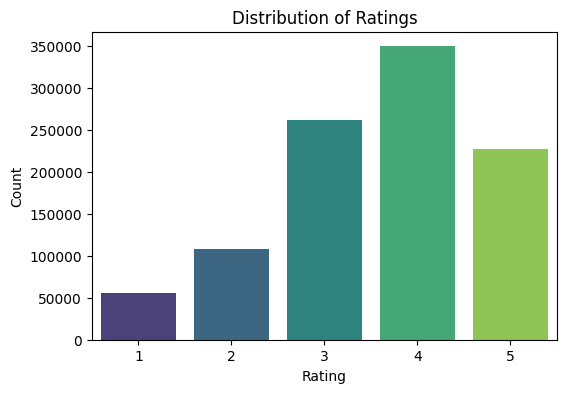

In [6]:
# Distribution of ratings
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=ratings_and_titles, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Top 10 most rated Movies

/tmp/ipython-input-3672969183.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette='plasma')


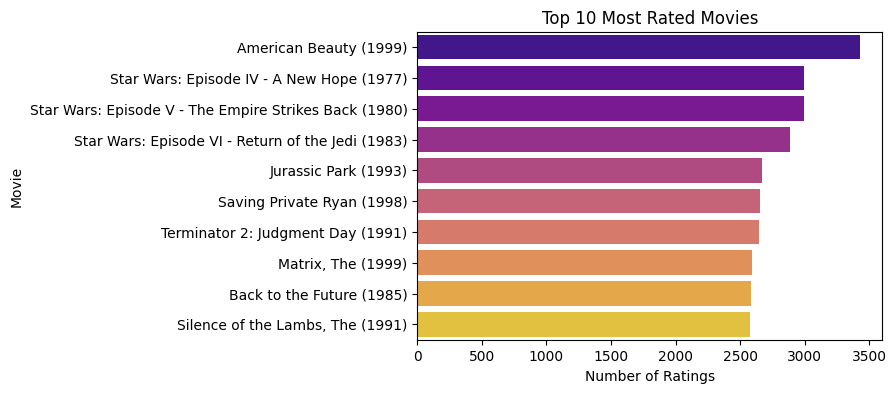

In [7]:
top_movies = ratings_and_titles.groupby('title')['rating'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='plasma')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie')
plt.show()

Number of Ratings per User

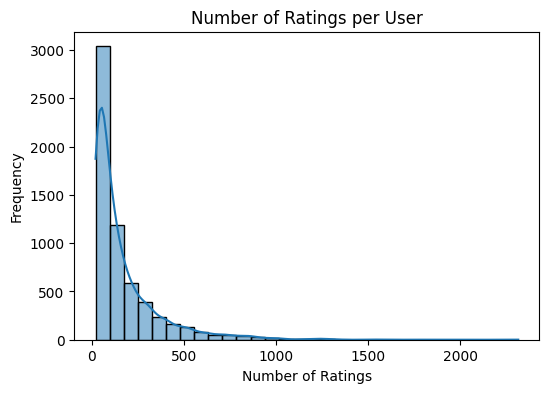

In [8]:
# Ratings per user distribution
plt.figure(figsize=(6,4))
sns.histplot(ratings_and_titles.groupby('user_id')['rating'].count(), bins=30, kde=True)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Sparsity of the Rating Matrix
num_users = ratings_and_titles['user_id'].nunique()
num_items = ratings_and_titles['item_id'].nunique()
num_ratings = len(ratings_and_titles)

sparsity = 1 - (num_ratings / (num_users * num_items))
print(f"{sparsity * 100:.2f}% of the Rating matrix would be sparse")

95.53% of the Rating matrix would be sparse


Top 10 most active users

/tmp/ipython-input-2496586807.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index, y=top_users.values, palette='magma')


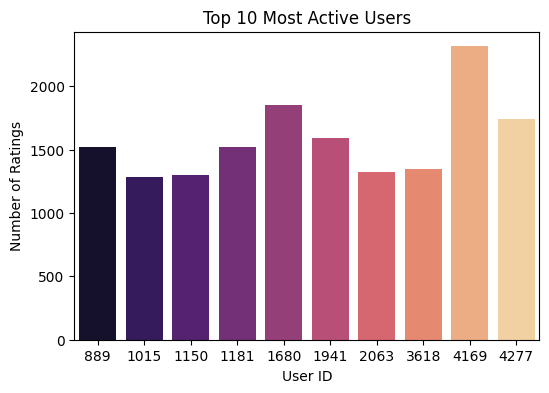

In [10]:
# Top 10 most active users
ratings_per_user = ratings_and_titles.groupby('user_id')['rating'].count()
top_users = ratings_per_user.sort_values(ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=top_users.index, y=top_users.values, palette='magma')
plt.title('Top 10 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.show()

Ensure Reproducibility

In [11]:

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Force deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Combine Users, Items, Ratings and Genres

In [13]:
rating_and_genres = ratings_and_titles[["user_idx", "item_idx", "rating"] + genre_names].copy()
rating_and_genres.head(10)

,user_idx,item_idx,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,5,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,5,3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0,6,5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,7,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,8,4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,9,4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Prepare Train, Validation and Test Sets

In [14]:

# Split into train / test
train_df, test_df = train_test_split(rating_and_genres, test_size=0.2, random_state=42)

# 10% of train as validation (so 72% train, 8% val of total dataset)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# 2. Dataset / DataLoader definitions
class RatingDataset(Dataset):
    def __init__(self, df, genre_names):
        super().__init__()
        self.user_idx = df["user_idx"].values
        self.item_idx = df["item_idx"].values
        self.ratings = df["rating"].values.astype(np.float32)
        self.genres = df[genre_names].values.astype(np.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.user_idx[idx], dtype=torch.long),
            torch.tensor(self.item_idx[idx], dtype=torch.long),
            torch.tensor(self.genres[idx], dtype=torch.float32),
            torch.tensor(self.ratings[idx], dtype=torch.float32),

        )

# Consider the three columns: user_idx, item_idx and ratings

train_dataset = RatingDataset(train_df, genre_names)
val_dataset = RatingDataset(val_df, genre_names)
test_dataset = RatingDataset(test_df, genre_names)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


Training set size: 720150
Validation set size: 80017
Test set size: 200042


Define NeuMF model with Attention Mechanism

In [21]:
import torch.nn.functional as F


class NCF(nn.Module):
    def __init__(self, n_users, n_items, n_genres, embed_dim=32, mlp_layers=[64,32,16,8]):
        super().__init__()

        # Embedding layers
        self.user_embed_mf = nn.Embedding(n_users, embed_dim)
        self.item_embed_mf = nn.Embedding(n_items, embed_dim)

        self.user_embed_mlp = nn.Embedding(n_users, embed_dim)
        self.item_embed_mlp = nn.Embedding(n_items, embed_dim)

        # MLP layers
        mlp_input_size = 2 * embed_dim + n_genres
        mlp_layers_sizes = [mlp_input_size] + mlp_layers
        mlp_modules = []
        for i in range(len(mlp_layers_sizes) - 1):
            mlp_modules.append(nn.Linear(mlp_layers_sizes[i], mlp_layers_sizes[i + 1]))
            mlp_modules.append(nn.BatchNorm1d(mlp_layers_sizes[i + 1]))  # Batch Normalization
            mlp_modules.append(nn.ReLU())
            mlp_modules.append(nn.Dropout(p=0.3))
        self.mlp = nn.Sequential(*mlp_modules)

        # Attention network
        att_input_dim = 1 + mlp_layers[-1]
        self.attention_net = nn.Sequential(
            nn.Linear(att_input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

        # Projection for MLP branch
        self.mlp_proj = nn.Linear(mlp_layers[-1], 1)

        # Final prediction layer
        self.predict_layer = nn.Linear(1, 1)

        # Weight initialization
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.user_embed_mf.weight, std=0.02)
        nn.init.normal_(self.item_embed_mf.weight, std=0.02)
        nn.init.normal_(self.user_embed_mlp.weight, std=0.02)
        nn.init.normal_(self.item_embed_mlp.weight, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, user_idx, item_idx, genres):
        # MF branch
        mf_user = self.user_embed_mf(user_idx)
        mf_item = self.item_embed_mf(item_idx)
        mf_out = (mf_user * mf_item).sum(dim=1, keepdim=True)

        # MLP branch
        mlp_user = self.user_embed_mlp(user_idx)
        mlp_item = self.item_embed_mlp(item_idx)
        mlp_in = torch.cat([mlp_user, mlp_item, genres], dim=1)
        mlp_out = self.mlp(mlp_in)

        # Attention computation
        att_in = torch.cat([mf_out, mlp_out], dim=1)
        att_scores = self.attention_net(att_in)
        att_weights = F.softmax(att_scores, dim=1)

        alpha_mf = att_weights[:, 0].unsqueeze(1)
        alpha_mlp = att_weights[:, 1].unsqueeze(1)

        # Weighted fusion
        mlp_proj = self.mlp_proj(mlp_out)
        combined = alpha_mf * mf_out + alpha_mlp * mlp_proj

        # --- Final prediction ---
        out = self.predict_layer(combined)
        out = torch.sigmoid(out) * 4 + 1  # [0,1] -> [1,5]
        return out.squeeze(1)

Define Loss Function

In [22]:
criterion = nn.SmoothL1Loss()

Hyperparameter Tuning


In [25]:
embed_dims = [16, 32, 64]
mlp_layers_options = [[64,32,16,8], [128,64,32,16], [32,16,8,4]]
lrs = [1e-4, 5e-4, 1e-3]
weight_decays = [0, 1e-5, 1e-4]
batch_sizes = [256, 512, 1024]

best_val_loss = float('inf')
best_config = None

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

for _ in range(20):  # random search
    embed_dim = random.choice(embed_dims)
    mlp_layers = random.choice(mlp_layers_options)
    lr = random.choice(lrs)
    weight_decay = random.choice(weight_decays)
    batch_size = random.choice(batch_sizes)

    model = NCF(n_users, n_items, n_genres=len(genre_names), embed_dim=embed_dim, mlp_layers=mlp_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for user, item, genres, rating in train_loader:
            user, item, genres, rating = user.to(device), item.to(device), genres.to(device), rating.to(device)
            optimizer.zero_grad()
            output = model(user, item, genres)
            loss = criterion(output, rating)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, item, genres, rating in val_loader:
            user, item, genres, rating = user.to(device), item.to(device), genres.to(device), rating.to(device)
            output = model(user, item, genres)
            loss = criterion(output, rating)
            val_loss += loss.item() * len(user)
    val_loss /= len(val_dataset)

    # Track best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_config = (embed_dim, mlp_layers, lr, weight_decay, batch_size)

    print(f"Config: {embed_dim, mlp_layers, lr, weight_decay, batch_size} -> val_loss: {val_loss}")

print("Best config:", best_config, "Validation loss:", best_val_loss)

best_embed, best_layers, best_lr, best_wd, best_bs = best_config

print()
print("Best Hyperparameters Found:")
print(f"Embedding Dimension : {best_embed}")
print(f"MLP Layers          : {best_layers}")
print(f"Learning Rate       : {best_lr}")
print(f"Weight Decay        : {best_wd}")
print(f"Batch Size          : {best_bs}")
print(f"Validation Loss     : {best_val_loss:.4f}")

Config: (64, [64, 32, 16, 8], 0.0001, 0.0001, 512) -> val_loss: 0.3535662341711097
Config: (16, [64, 32, 16, 8], 0.0001, 0.0001, 256) -> val_loss: 0.38605425801912946
Config: (64, [32, 16, 8, 4], 0.001, 0, 1024) -> val_loss: 0.37763873153092664
Config: (32, [64, 32, 16, 8], 0.0001, 0, 256) -> val_loss: 0.36032106724279656
Config: (16, [32, 16, 8, 4], 0.001, 0, 1024) -> val_loss: 0.3565889721575716
Config: (16, [32, 16, 8, 4], 0.001, 0.0001, 1024) -> val_loss: 0.3592562347291859
Config: (32, [64, 32, 16, 8], 0.0005, 0.0001, 512) -> val_loss: 0.34355006573333324
Config: (16, [64, 32, 16, 8], 0.001, 1e-05, 512) -> val_loss: 0.3492651026944251


KeyboardInterrupt: 

Use the best Parameters


In [53]:
model = NCF(n_users, n_items, n_genres=len(genre_names), embed_dim=64, mlp_layers=[64, 32, 16, 8]).to(device)
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00005)

NCF(
  (user_embed_mf): Embedding(6040, 64)
  (item_embed_mf): Embedding(3706, 64)
  (user_embed_mlp): Embedding(6040, 64)
  (item_embed_mlp): Embedding(3706, 64)
  (mlp): Sequential(
    (0): Linear(in_features=146, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=16, out_features=8, bias=True)
    (13): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=Fa

Training and Evaluation

Epoch 1/50 — Train MSE: 0.5669, Test RMSE: 0.6782
Epoch 2/50 — Train MSE: 0.4482, Test RMSE: 0.6152
Epoch 3/50 — Train MSE: 0.4004, Test RMSE: 0.6050
Epoch 4/50 — Train MSE: 0.3835, Test RMSE: 0.5999
Epoch 5/50 — Train MSE: 0.3740, Test RMSE: 0.5973
Epoch 6/50 — Train MSE: 0.3677, Test RMSE: 0.5961
Epoch 7/50 — Train MSE: 0.3637, Test RMSE: 0.5950
Epoch 8/50 — Train MSE: 0.3607, Test RMSE: 0.5939
Epoch 9/50 — Train MSE: 0.3579, Test RMSE: 0.5932
Epoch 10/50 — Train MSE: 0.3556, Test RMSE: 0.5935
Epoch 11/50 — Train MSE: 0.3535, Test RMSE: 0.5927
Epoch 12/50 — Train MSE: 0.3510, Test RMSE: 0.5916
Epoch 13/50 — Train MSE: 0.3490, Test RMSE: 0.5901
Epoch 14/50 — Train MSE: 0.3462, Test RMSE: 0.5897
Epoch 15/50 — Train MSE: 0.3447, Test RMSE: 0.5888
Epoch 16/50 — Train MSE: 0.3423, Test RMSE: 0.5877
Epoch 17/50 — Train MSE: 0.3405, Test RMSE: 0.5873
Epoch 18/50 — Train MSE: 0.3377, Test RMSE: 0.5854
Epoch 19/50 — Train MSE: 0.3356, Test RMSE: 0.5843
Epoch 20/50 — Train MSE: 0.3335, Test RM

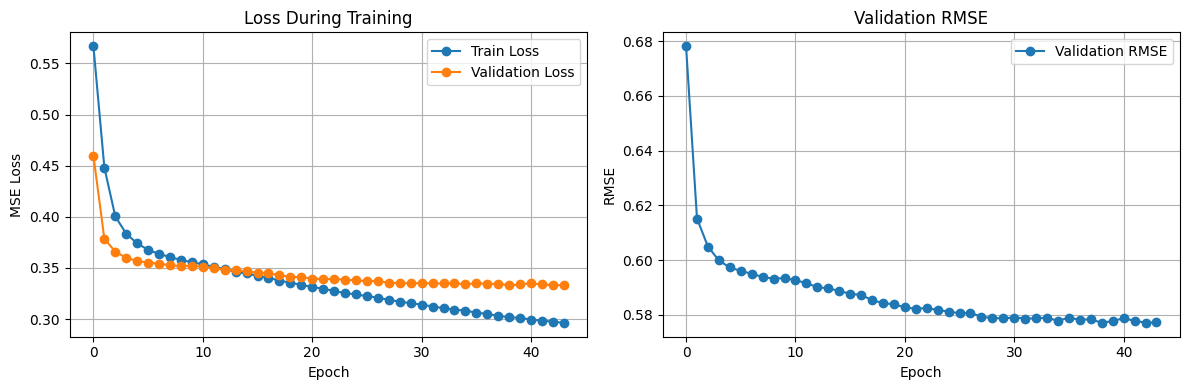

In [54]:
# 5. Training loop with Early Stopping
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for (user, item, genres, rating) in loader:
        user = user.to(device)
        item = item.to(device)
        genres = genres.to(device)
        rating = rating.to(device)

        optimizer.zero_grad(set_to_none=True)
        pred = model(user, item, genres)
        loss = criterion(pred, rating)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * user.size(0)
    return total_loss / len(loader.dataset)


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    y_true_r, y_pred_r = [], []

    with torch.no_grad():
        for (user, item, genres, rating) in loader:
            user = user.to(device)
            item = item.to(device)
            genres = genres.to(device)
            rating = rating.float().to(device)
            pred = model(user, item, genres)
            y_true_r.append(rating.cpu())
            y_pred_r.append(pred.cpu())
            loss = criterion(pred, rating)
            total_loss += loss.item() * user.size(0)

    y_true = torch.cat(y_true_r).numpy()
    y_pred = torch.cat(y_pred_r).numpy()
    mse = total_loss / len(loader.dataset)
    return mse, np.sqrt(mse), y_true, y_pred


# Initialize history dictionary
history = {
    'train_loss': [],
    'val_loss': [],
    'val_rmse': [],
    'y_true_test': [],
    'y_pred_test': []
}

n_epochs = 50
patience = 5  # early stopping patience
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

for epoch in range(n_epochs):
    # Training
    train_mse = train_one_epoch(model, train_loader, optimizer, criterion, device)
    history['train_loss'].append(train_mse)

    # Validation
    val_mse, val_rmse, y_true_test, y_pred_test = evaluate(model, test_loader, criterion, device)
    history['val_loss'].append(val_mse)
    history['val_rmse'].append(val_rmse)
    history['y_true_test'].append(y_true_test)
    history['y_pred_test'].append(y_pred_test)

    print(f"Epoch {epoch+1}/{n_epochs} — Train MSE: {train_mse:.4f}, Test RMSE: {val_rmse:.4f}")

    # Early Stopping Logic
    if val_mse < best_val_loss - 1e-4:  # consider small improvement significant
        best_val_loss = val_mse
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n⏸️ Early stopping triggered at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("\n✅ Restored best model weights from epoch with lowest validation loss.")

# Plotting
plt.figure(figsize=(12, 4))

# Left subplot: Loss curves
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Right subplot: Validation RMSE
plt.subplot(1, 2, 2)
plt.plot(history['val_rmse'], label='Validation RMSE', marker='o')
plt.title('Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Saving Training results

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import os
save_dir = "/content/drive/MyDrive/NeuralCF"
os.makedirs(save_dir, exist_ok=True)
print(f"📁 All files will be saved to: {save_dir}")

# Save Model + Optimizer + Metrics
checkpoint_path = os.path.join(save_dir, "model_checkpoint.pth")

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "history": history,
    'y_true_last': y_true_test_last,
    'y_pred_last': y_pred_test_last
}, checkpoint_path)

print(f"Model and training info saved to {checkpoint_path}")

# Save History as CSV
df = pd.DataFrame({
    'epoch': range(1, len(history['train_loss']) + 1),
    'train_loss': history['train_loss'],
    'val_loss': history['val_loss'],
    'val_rmse': history['val_rmse']
})
csv_path = os.path.join(save_dir, "training_history.csv")
df.to_csv(csv_path, index=False)
print(f"Training history saved to: {csv_path}")

📁 All files will be saved to: /content/drive/MyDrive/NeuralCF
Model and training info saved to /content/drive/MyDrive/NeuralCF/model_checkpoint.pth
Training history saved to: /content/drive/MyDrive/NeuralCF/training_history.csv


Load the saved results

In [40]:
checkpoint_path = "/content/drive/MyDrive/NeuralCF/model_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
y_true_last = checkpoint['y_true_last']
y_pred_last = checkpoint['y_pred_last']

print("Model and all saved info loaded successfully!")

Model and all saved info loaded successfully!


In [62]:
# 6. Recommendation function

itemid_to_title = (ratings_and_titles.set_index("item_id")["title"].to_dict()
)

def recommend_for_user(user_id, top_k):
    # user_id is original id (not index)
    if user_id not in user2idx:
        print("Unknown user")
        return []

    uidx = user2idx[user_id]
    u_tensor = torch.tensor([uidx], dtype=torch.long, device=device)

    preds_list = []

    # Predict for all items
    # Construct item_idx tensor
    all_items = torch.arange(n_items, dtype=torch.long, device=device)
    u_expand = u_tensor.expand(n_items)

    genre_list = [idx2genre[i.item()].to(device) for i in all_items]
    genres_tensor = torch.stack(genre_list)

    preds = model(u_expand, all_items, genres_tensor).detach().cpu().numpy()

    # map from item_idx to item_id
    idx2item = {v: k for k, v in item2idx.items()}
    item2idx_inv = {k: v for v, k in item2idx.items()}

    # Get top K items (excluding ones the user already rated)
    rated = set(train_df[train_df["user_idx"] == uidx]["item_idx"].tolist())

    ranked = np.argsort(-preds)  # descending order

    recs = []
    for idx in ranked:
        iid = idx2item[idx]
        if iid not in rated:
            title = itemid_to_title.get(iid, "Unknown Title")
            recs.append((iid, title))
            if len(recs) >= top_k:
                break

    rec_df = pd.DataFrame(recs, columns=["item_id", "title"])

    return rec_df

# Example
sample_user = ratings["user_id"].iloc[1]
recommendations_df = recommend_for_user(sample_user, top_k=5)
print(f"\nTop 5 recommendations for user {sample_user}:")
display(recommendations_df)

# Get top 5 films rated by the specific user
user_rated = ratings_and_titles[ratings_and_titles["user_id"] == sample_user]
top_rated = user_rated.sort_values(by="rating", ascending=False).head(5)
top_rated = top_rated[["item_id", "title", "rating"]]

print(f"\nTop 5 movies rated by user {sample_user}:")
top_rated.head()


Top 5 recommendations for user 1:


,item_id,title
0,527,Schindler's List (1993)
1,318,"Shawshank Redemption, The (1994)"
2,1198,Raiders of the Lost Ark (1981)
3,2762,"Sixth Sense, The (1999)"
4,110,Braveheart (1995)



Top 5 movies rated by user 1:


,item_id,title,rating
0,1193,One Flew Over the Cuckoo's Nest (1975),5
4,2355,"Bug's Life, A (1998)",5
10,595,Beauty and the Beast (1991),5
7,2804,"Christmas Story, A (1983)",5
6,1287,Ben-Hur (1959),5


Files to Export

In [ ]:
import pickle, os, pandas as pd

# Directory to save export files
export_dir = "/content/drive/MyDrive/ncf_export"
os.makedirs(export_dir, exist_ok=True)

In [ ]:
# ✅ Save user and item mappings
with open(f"{export_dir}/user_mapping.pkl", "wb") as f:
    pickle.dump(user2idx, f)

with open(f"{export_dir}/item_mapping.pkl", "wb") as f:
    pickle.dump(item2idx, f)

In [ ]:
# Create simple metadata file with item_id and title
metadata = movies[["item_id", "title"]].copy()
metadata.to_csv("item_metadata.csv", index=False)
print("✅ item_metadata.csv saved:", len(metadata), "movies")

✅ item_metadata.csv saved: 1682 movies


In [61]:
# Save and Download the final model

from google.colab import files
torch.save(model.state_dict(), "ncf_model_final.pth")
files.download("ncf_model_final.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save Movies to CSV for inference
movies.to_csv("movies.csv", index=False)

print("✅ movies.csv created successfully!")

✅ movies.csv created successfully!


In [ ]:
# Download movies.csv

from google.colab import files
files.download("movies.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>